In [6]:
                                   #Parameter Estimation with Python Scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
import pandas as pd

data = np.loadtxt('data.txt',delimiter=',',skiprows=1)        
# extract data columns
t = data[:,0].T  
S = data[:,1].T                                                                                             
X = data[:,2].T                                                                                      
P = data[:,3].T   

# number of time points
ns = len(t)                                                  

# define biomass growth model 
def growth(x,t,S,X,P,p):    ###                                   
    # Optimized parameters
    Yps,Ks,umax,Qmax = p

    # Parameters and initial conditions
    F = 0.015  #Biomass dosing flow
    V = 1 #Volume of reactor
    Xmax = 9.577 #Maximum biomass concentration
    
    #function that defines u(t)
    def u( t ):  return ( (umax*S)/(Ks+S) ) * ( 1 -(X/Xmax) ) 
    # ODE equations
    dSdt = ((-1/Yps)*u(t)*X) + ((F/V)*X)
    dXdt = (u(t)*X) - ((F/V)*X)
    dPdt = (((Qmax * S)/(S + Ks))) - ((F/V)*P) 
    return [dSdt,dXdt,dPdt]

#function that simulates the model based on values from dataset
def simulate(p):
    T = np.zeros((len(t),3))
    T[0,0] = S[0]
    T[0,1] = X[0] 
    T[0,2] = P[0] 
    T0 = T[0]
    for i in range(len(t)-1):
        ts = [t[i],t[i+1]]
        y = odeint(growth,T0,ts,args=(S[i],X[i],P[i],p))  
        T0 = y[-1]
        T[i+1] = T0
    return T
    
# define objective
def objective(p):
    # simulate model
    Tp = simulate(p)
    # calculate objective
    obj = 0.0
    for i in range(len(t)): 
        obj += ((Tp[i,0]-S[i])/S[i])**2 \
              +((Tp[i,1]-X[i])/X[i])**2 \
              +((Tp[i,2]-P[i])/P[i])**2 
    # return result
    return obj

# Parameter initial guess
Yps = 0.11  #0.11
Ks = 32  #34
umax = 0.43  #0.41
Qmax = 1.28  #1.33
p0 = [Yps,Ks,umax,Qmax]

# show initial objective
print('Initial SSE Objective: ' + str(objective(p0)))

# optimize parameters
# bounds on variables
bnds = ((0.085, 0.11),(29,34),(0.4,0.45),(1.25,1.50))
solution = minimize(objective,p0,method='SLSQP',bounds=bnds)
p = solution.x

# show final objective
print('Final SSE Objective: ' + str(objective(p)))

# optimized parameter values
Yps = p[0]
Ks = p[1]
umax = p[2]
Qmax = p[3]

#display values and calculate percent difference between optimized and expected values
print(f'Yps initial guess: {p0[0]:.2f} || Yps optimized: {Yps:.2f} || expected value = 0.11')
print(f'Ks initial guess: {p0[1]:.2f} || Ks optimized: {Ks:.2f} || expected value = 34')
print(f'umax initial guess: {p0[2]:.2f} || umax optimized: {umax:.2f} || expected value = 0.41')
print(f'Qmax initial guess: {p0[3]:.2f} || Qmax optimized: {Qmax:.2f} || expected value = 1.33')

per_diff_Yps = abs((0.11 - p[0])/0.11)*100
per_diff_Ks = abs((34 - p[1])/34)*100
per_diff_umax = abs((0.41 - p[2])/0.41)*100
per_diff_Qmax = abs((1.33 - p[3])/1.33)*100
print('%Difference between optimized and expected values:')
print(f'1-Difference of Yps = {per_diff_Yps:.2f}%')
print(f'2-Difference of Ks = {per_diff_Ks:.2f}%')
print(f'3-Difference of umax = {per_diff_umax:.2f}%')
print(f'4-Difference of Qmax = {per_diff_Qmax:.2f}%')

# calculate model with updated parameters
Ti  = simulate(p0)
Tp  = simulate(p)

Initial SSE Objective: 4703.460864759752
Final SSE Objective: 4479.5578189897105
Yps initial guess: 0.11 || Yps optimized: 0.11 || expected value = 0.11
Ks initial guess: 32.00 || Ks optimized: 34.00 || expected value = 34
umax initial guess: 0.43 || umax optimized: 0.45 || expected value = 0.41
Qmax initial guess: 1.28 || Qmax optimized: 1.43 || expected value = 1.33
%Difference between optimized and expected values:
1-Difference of Yps = 0.00%
2-Difference of Ks = 0.00%
3-Difference of umax = 9.76%
4-Difference of Qmax = 7.32%


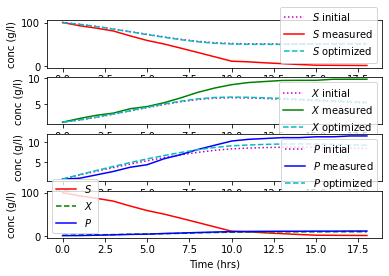

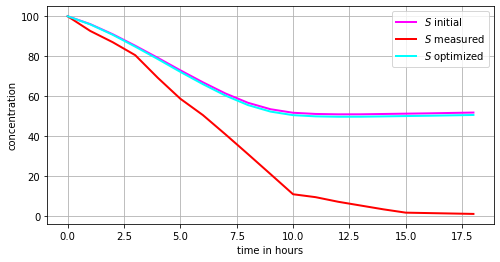

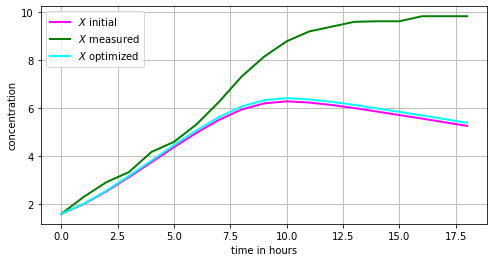

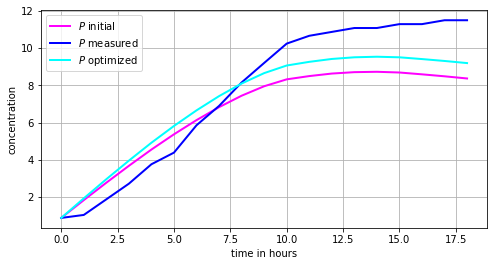

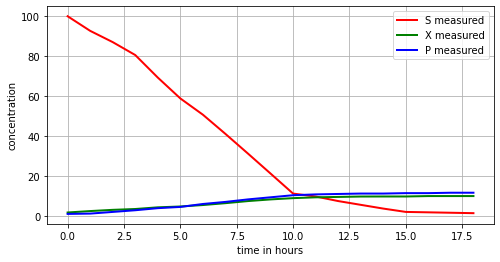

In [7]:
###plot results

# 1st set of plots
ax = plt
plt.figure(1)

ax.subplot(4,1,1)
ax.plot(t,Ti[:,0],'m:',label=r'$S$ initial')
ax.plot(t,S,'r-',label=r'$S$ measured')
ax.plot(t,Tp[:,0],'c--',label=r'$S$ optimized')
ax.ylabel('conc (g/l)')
ax.legend(loc='best')

ax.subplot(4,1,2)
ax.plot(t,Ti[:,1],'m:',label=r'$X$ initial')
ax.plot(t,X,'g-',label=r'$X$ measured')
ax.plot(t,Tp[:,1],'c--',label=r'$X$ optimized')
ax.ylabel('conc (g/l)')
ax.legend(loc='best')

ax.subplot(4,1,3)
ax.plot(t,Ti[:,2],'m:',label=r'$P$ initial')
ax.plot(t,P,'b-',label=r'$P$ measured')
ax.plot(t,Tp[:,2],'c--',label=r'$P$ optimized')
ax.ylabel('conc (g/l)')
ax.legend(loc='best')

ax.subplot(4,1,4)
ax.plot(t,S,'r-',label=r'$S$')
ax.plot(t,X,'g--',label=r'$X$')
ax.plot(t,P,'b-',label=r'$P$')
ax.ylabel('conc (g/l)')
ax.legend(loc='best')

ax.xlabel('Time (hrs)')
ax.show()


#2nd set of plots
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(t, Ti[:, 0], linewidth=2, color='magenta', label='$S$ initial')
ax.plot(t, S, linewidth=2, color='red', label='$S$ measured')
ax.plot(t, Tp[:, 0], linewidth=2, color='cyan', label='$S$ optimized')
ax.set_xlabel('time in hours')
ax.set_ylabel('concentration')
ax.legend()
ax.grid()

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(t, Ti[:, 1], linewidth=2, color='magenta', label='$X$ initial')
ax.plot(t, X, linewidth=2, color='green', label='$X$ measured')
ax.plot(t, Tp[:, 1], linewidth=2, color='cyan', label='$X$ optimized')
ax.set_xlabel('time in hours')
ax.set_ylabel('concentration')
ax.legend()
ax.grid()

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(t, Ti[:, 2], linewidth=2, color='magenta', label='$P$ initial')
ax.plot(t, P, linewidth=2, color='blue', label='$P$ measured')
ax.plot(t, Tp[:, 2], linewidth=2, color='cyan', label='$P$ optimized')
ax.set_xlabel('time in hours')
ax.set_ylabel('concentration')
ax.legend()
ax.grid()

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(t, S, linewidth=2, color='red', label='S measured')
ax.plot(t, X, linewidth=2, color='green', label='X measured')
ax.plot(t, P, linewidth=2, color='blue', label='P measured')
ax.set_xlabel('time in hours')
ax.set_ylabel('concentration')
ax.legend()
ax.grid()